In [38]:
import os
import csv
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import (
    regexp_replace,
    regexp_extract_all,
    col,
    lit
)

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [3]:
conf = create_spark_configuration()

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user0/.ivy2/cache
The jars for the packages stored in: /home/user0/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-020cf246-37c0-4fd4-8417-34241d68c4ad;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 586ms :: artifacts dl 19ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

In [6]:
# Список всех баз данных в Spark
databases = spark.catalog.listDatabases()

# Вывод имён баз данных
for db in databases:
    print(db.name)


Shaheen_database
abrosimov_database
abrosimov_database2
akopian_database
grigorev_database
grigorev_database_new
grigorev_database_new_1
gysynin_dmitry_database
ivanov_database
moschenko_database
petrov_database
samorokov_database
samorokov_db
samorokov_db_new
samorokov_db_new_small
semen_database
semen_lab1
shaheen_database
utin_database
utin_ilya_database
utin_ilya_database1
zaporozhski_database


In [7]:
database_name = "samorokov_db_new_small"

In [8]:
# Создадим инструкцию SQL для добавления базы данных в каталог Apache Spark
create_database_sql = f"""
CREATE DATABASE IF NOT EXISTS spark_catalog.{database_name}
"""

In [9]:
spark.sql(create_database_sql)

DataFrame[]

In [10]:
# Установим БД, как текущую
spark.catalog.setCurrentDatabase(database_name)

In [11]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_table_new_small


In [14]:
# Прочитаем таблчку из БД
df = spark.table("sobd_table_new_small").limit(1000)

# Выведем табличку на экран
df.show()

+---+-------+----------+-------+------+
|Ply|GamePly|HasCastled|   Eval|Result|
+---+-------+----------+-------+------+
|110|    157|         2|  305.0|   1.0|
| 29|    238|         3|  108.0|   0.5|
| 40|    231|         3|   46.0|   1.0|
| 44|    111|         3|  236.0|   1.0|
| 38|    165|         0|   37.0|   0.5|
| 54|    119|         3|  223.0|   0.5|
| 93|    129|         3|  450.0|   1.0|
| 43|    141|         3|  112.0|   1.0|
|100|    114|         3|-1894.0|   0.0|
| 80|    119|         2|  198.0|   0.5|
| 28|     46|         3|   -8.0|   0.0|
| 34|    197|         3|   -3.0|   1.0|
| 32|    110|         3|  -79.0|   0.0|
| 14|    103|         1|   59.0|   0.5|
| 24|     93|         3|  108.0|   1.0|
| 45|    112|         3|   63.0|   0.5|
| 38|     69|         3|   30.0|   1.0|
| 78|     92|         3|  215.0|   1.0|
| 73|    161|         3|  -23.0|   0.0|
| 64|     75|         3|  396.0|   1.0|
+---+-------+----------+-------+------+
only showing top 20 rows



In [15]:
df.count()

1000

In [16]:
# Посмотрим на схему данных 
df.printSchema()

root
 |-- Ply: integer (nullable = true)
 |-- GamePly: integer (nullable = true)
 |-- HasCastled: integer (nullable = true)
 |-- Eval: float (nullable = true)
 |-- Result: float (nullable = true)



In [17]:
from pyspark.sql.functions import when, col

def binary_transform(df: DataFrame) -> DataFrame:
    # Бинаризация столбца 'HasCastled'
    df = df.withColumn('HasCastled', when(col('HasCastled') == 0, 0)
                                  .otherwise(1))
    
    # Бинаризация столбца 'Result'
    df = df.withColumn('Result', when(col('Result') == 0.5, 0)
                                  .otherwise(col('Result')))
    
    # Возвращаем обновленный DataFrame
    return df

# Применяем бинаризацию к данным
df = binary_transform(df)

# Выводим первые несколько строк преобразованного DataFrame для проверки
df.show(15)


+---+-------+----------+-------+------+
|Ply|GamePly|HasCastled|   Eval|Result|
+---+-------+----------+-------+------+
|110|    157|         1|  305.0|   1.0|
| 29|    238|         1|  108.0|   0.0|
| 40|    231|         1|   46.0|   1.0|
| 44|    111|         1|  236.0|   1.0|
| 38|    165|         0|   37.0|   0.0|
| 54|    119|         1|  223.0|   0.0|
| 93|    129|         1|  450.0|   1.0|
| 43|    141|         1|  112.0|   1.0|
|100|    114|         1|-1894.0|   0.0|
| 80|    119|         1|  198.0|   0.0|
| 28|     46|         1|   -8.0|   0.0|
| 34|    197|         1|   -3.0|   1.0|
| 32|    110|         1|  -79.0|   0.0|
| 14|    103|         1|   59.0|   0.0|
| 24|     93|         1|  108.0|   1.0|
+---+-------+----------+-------+------+
only showing top 15 rows



### Проведем балансировку данных 
##### (проверим как значения целевой переменной схожи с друг другом по соотношению (сколько 0 и 1))

Количество 1.0: 367
Количество 0.0: 633


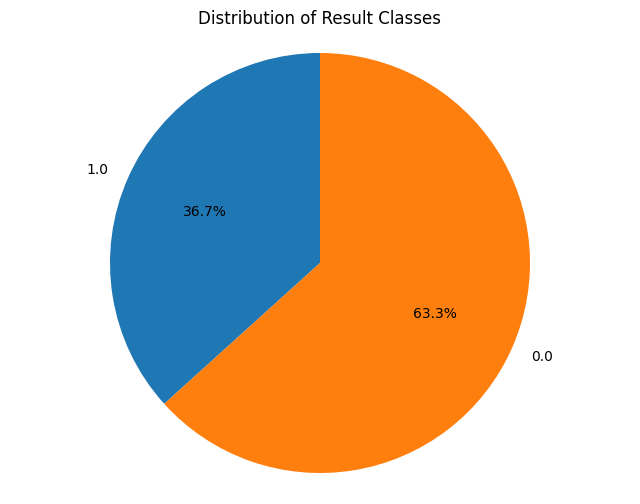

In [69]:
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

def check_balance(data: DataFrame) -> None:
    """
    Проверяет баланс классов в столбце Result и строит круговую диаграмму.

    Args:
        data (DataFrame): DataFrame, содержащий столбец Result.
    """
    # Подсчет классов в столбце Result
    result_counts = data.groupBy('Result').count().collect()

    # Извлекаем значения
    labels = [row['Result'] for row in result_counts]
    counts = [row['count'] for row in result_counts]

    # Печатаем результаты
    for label, count in zip(labels, counts):
        print(f"Количество {label}: {count}")

    # Создание круговой диаграммы
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=[str(label) for label in labels], autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Result Classes - распределение классов результатов')
    plt.axis('equal')  
    plt.show()

# Вызов функции для проверки баланса классов
check_balance(df)  


In [18]:
# Разделим датасет на обучающую и тестовую
train_df, test_df = df.randomSplit([0.8, 0.2])

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 801


Test  dataset size: 199


In [20]:
# В качестве предсказуемого возьмем Result
binary_features = ["HasCastled"]
numeric_features = ["Eval", "GamePly", "Ply"]


In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import DataFrame

def create_logistic_regression_pipeline(binary_features: list[str], numeric_features: list[str], 
                                        label_col: str, max_iter: int) -> Pipeline:
    
    # Формируем названия колонок для преобразованных признаков
    # Для бинарных признаков создаем новые колонки с бинаризованными значениями
    # Для категориальных признаков индексация и one-hot encoding
    indexed_binary_features = [f"{feature}_index" for feature in binary_features]
    onehot_binary_features = [f"{feature}_ohe" for feature in binary_features]
    
    # Преобразование данных
    # Индексация бинарных признаков
    binary_indexer = StringIndexer(inputCols=binary_features, 
                                   outputCols=indexed_binary_features, 
                                   handleInvalid="skip")
    
    # OneHotEncoding бинарных признаков (если необходимо)
    binary_onehot_encoder = OneHotEncoder(
        inputCols=indexed_binary_features,
        outputCols=onehot_binary_features,
        dropLast=True,
        handleInvalid="keep"  # Обновлено: используем "keep"
    )
    
    # Преобразование числовых признаков в вектор
    vector_num_assembler = VectorAssembler(inputCols=numeric_features, 
                                           outputCol="numeric_vector")
    
    # Масштабирование числовых признаков
    numeric_scaler = MinMaxScaler(inputCol="numeric_vector", 
                                   outputCol="numeric_vector_scaled")
    
    # Объединяем все признаки в один вектор
    vector_all_assembler = VectorAssembler(inputCols=(onehot_binary_features + 
                                                     binary_features + 
                                                     ["numeric_vector_scaled"]),
                                           outputCol="features")
    
    # Создаем модель логистической регрессии
    logistic_regression = LogisticRegression(featuresCol="features", 
                                             labelCol=label_col, 
                                             predictionCol="prediction", 
                                             maxIter=max_iter)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=[
        binary_indexer, 
        binary_onehot_encoder, 
        vector_num_assembler, 
        numeric_scaler, 
        vector_all_assembler, 
        logistic_regression
    ])
    
    return pipeline


label_col = "Result"  # Если хочешь предсказать, было ли рокирование (для примера)

max_iter = 100  # Количество итераций для логистической регрессии

train_data = train_df 

# Создание конвейера для логистической регрессии
logistic_regression_pipeline = create_logistic_regression_pipeline(
    binary_features, numeric_features, label_col, max_iter
)

In [32]:
param_grid = ParamGridBuilder() \
    .addGrid(logistic_regression_pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic_regression_pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(logistic_regression_pipeline.getStages()[-1].maxIter, [50, 100, 200]) \
    .build()


In [33]:
cv_evaluator = RegressionEvaluator(labelCol="Result",
                                   predictionCol="prediction")

In [34]:
cross_validator = CrossValidator(estimator=logistic_regression_pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

In [35]:
# ЗАПУСК ОБУЧЕНИЯ МОДЕЛИ
cv_model = cross_validator.fit(train_data)

25/01/15 11:45:37 WARN CacheManager: Asked to cache already cached data.
25/01/15 11:45:37 WARN CacheManager: Asked to cache already cached data.
25/01/15 11:45:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Посмотрим, что за модель получилась

In [36]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "regParam": best_model.stages[-1].getRegParam(),
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params

In [37]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

regParam: 0.01
elasticNetParam: 1.0
maxIter: 50


AttributeError: 'BinaryLogisticRegressionTrainingSummary' object has no attribute 'rootMeanSquaredError'

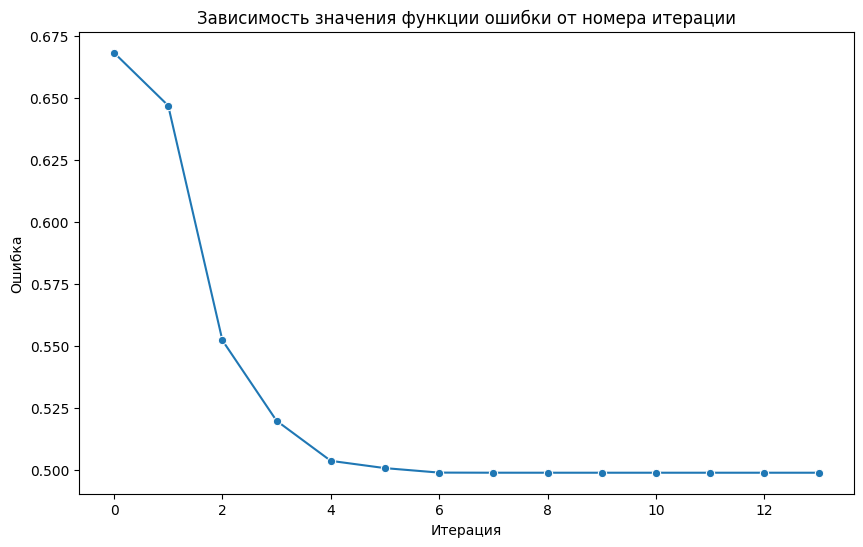

In [39]:
def plot_training_summary(cv_model: DataFrame) -> None:
    """
    Отображает графики зависимости значения ошибки от номера итерации на
    обучающей выборке, а также значения метрик RMSE и R^2.

    Args:
        cv_model (DataFrame): Обученная модель с использованием кросс-валидации.
    """
    # Получаем лучшую модель
    best_model = cv_model.bestModel

    # Получаем информацию о процессе обучения
    training_summary = best_model.stages[-1].summary

    # Получаем значения ошибки для каждой итерации
    objective_history = training_summary.objectiveHistory

    # Строим график зависимости значения ошибки от номера итерации
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(objective_history)), 
                 y=objective_history, 
                 marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Ошибка')
    plt.title("Зависимость значения функции ошибки от номера итерации")

    # Получаем значения метрик
    rmse = training_summary.rootMeanSquaredError
    r2 = training_summary.r2

    # Добавляем значения метрик на график
    plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR^2: {r2:.2f}",
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.grid()

    plt.show()
    
plot_training_summary(cv_model)

### Проверка обобщающей способности модели

##### Выполним предсказания на тестовой выборке.

##### Перегруппируем колонки датафрейма, переставив столбец с ценой автомобиля в конец, чтобы его значения было удобно сравнивать с предсказанными.

In [41]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("Result")
right_columns_order.append("Result")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+---+-------+----------+------+----------------+--------------+-------------------+---------------------+--------------------+--------------------+--------------------+----------+------+
|Ply|GamePly|HasCastled|  Eval|HasCastled_index|HasCastled_ohe|     numeric_vector|numeric_vector_scaled|            features|       rawPrediction|         probability|prediction|Result|
+---+-------+----------+------+----------------+--------------+-------------------+---------------------+--------------------+--------------------+--------------------+----------+------+
| 14|     47|         0|  19.0|             1.0| (2,[1],[1.0])|   [19.0,47.0,14.0]| [0.40791027154663...|[0.0,1.0,0.0,0.40...|[-0.1023263736078...|[0.47444070465494...|       1.0|   0.0|
| 15|    107|         1|  -6.0|             0.0| (2,[0],[1.0])|  [-6.0,107.0,15.0]| [0.40422077922077...|[1.0,0.0,1.0,0.40...|[0.47992334597282...|[0.61772977387360...|       0.0|   1.0|
| 16|    137|         1|   4.0|             0.0| (2,[0],[1.0])|  

In [53]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol="Result", 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

In [54]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE on test data: {test_rmse:.2f}")
print(f"R^2 on test data: {test_r2:.2f}")

RMSE on test data: 0.46
R^2 on test data: 0.03


In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_classification_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель классификации с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "accuracy", "f1", "roc").

    Returns:
        float: Значение указанной метрики.
    """
    if metric_name == "roc":
        evaluator = BinaryClassificationEvaluator(labelCol="Result", 
                                                  rawPredictionCol="probability", 
                                                  metricName="areaUnderROC")
    elif metric_name in ["accuracy", "f1"]:
        evaluator = MulticlassClassificationEvaluator(labelCol="Result", 
                                                       predictionCol="prediction", 
                                                       metricName=metric_name)
    else:
        raise ValueError(f"Unsupported metric for classification: {metric_name}")

    metric_value = evaluator.evaluate(data)
    return metric_value


In [56]:
# Оценим модель на тестовых данных
test_auc = evaluate_classification_model(test_df_predictions, "roc")
test_accuracy = evaluate_classification_model(test_df_predictions, "accuracy")

print(f"AUC on test data: {test_auc:.2f}")
print(f"Accuracy on test data: {test_accuracy:.2f}")


AUC on test data: 0.84
Accuracy on test data: 0.78


Визуализация результатов обученяи модели

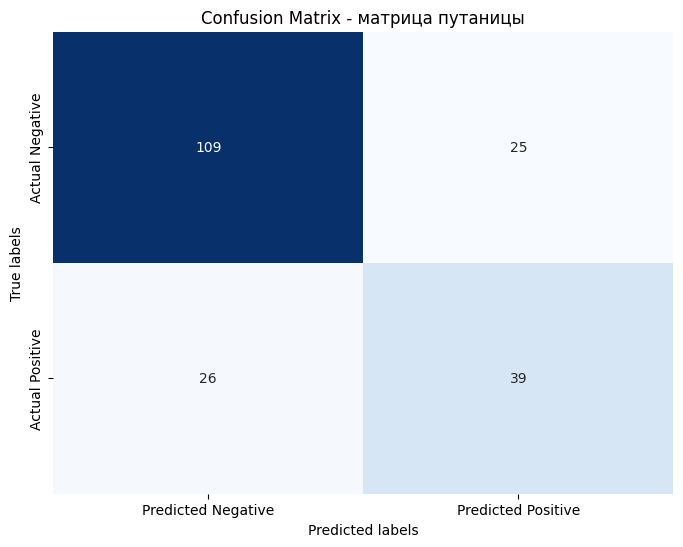

In [58]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(data: DataFrame) -> None:
    """
    Строит матрицу путаницы для оценивания модели.
    
    Показывает насколько точно данные предсказания попали или не попали

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
    """
    # Получаем фактические и предсказанные метки
    y_true = data.select('Result').toPandas().values.ravel()
    y_pred = data.select('prediction').toPandas().values.ravel()

    # Создаем матрицу путаницы
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - матрица путаницы')
    plt.show()

# Вызов функции для построения матрицы путаницы
plot_confusion_matrix(test_df_predictions)


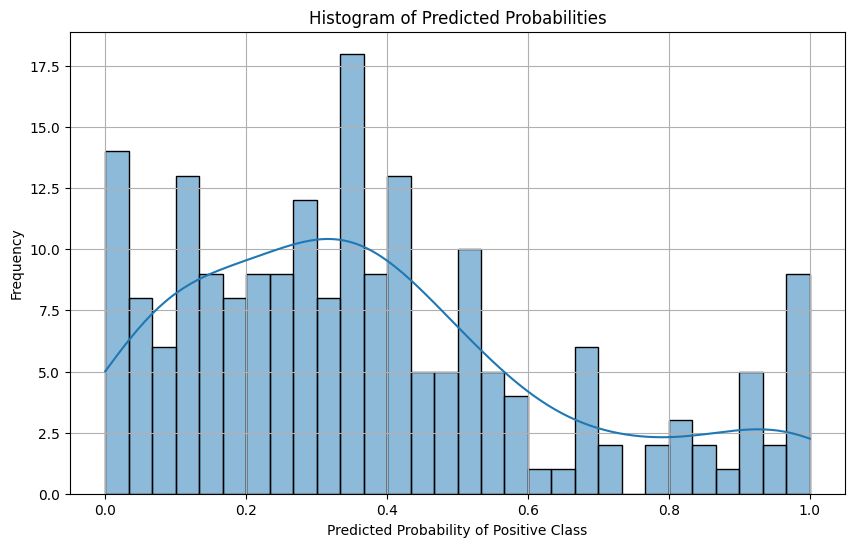

In [61]:
def plot_probability_histogram(data: DataFrame) -> None:
    """
    Построить гистограмму предсказанных вероятностей для положительного класса.

    - Если большинство предсказанных вероятностей положительного класса находятся близко к 1, это может означать,
      что модель уверена в своих положительных предсказаниях.
    - Если предсказанные вероятности распределены близко к 0.5, это может означать,
      что модель сталкивается с трудностями в классификации или не имеет четких границ между классами.
    
    Args:
        data (DataFrame): DataFrame, содержащий предсказанные вероятности.
    """
    probabilities = data.select('probability').toPandas()

    # Извлекаем вероятности положительного класса
    positive_class_probs = probabilities['probability'].apply(lambda x: x[1])
    
    plt.figure(figsize=(10, 6))
    sns.histplot(positive_class_probs, bins=30, kde=True)
    plt.xlabel('Predicted Probability of Positive Class')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Probabilities')
    plt.grid()
    plt.show()

# Вызов функции для построения гистограммы предсказанных вероятностей
plot_probability_histogram(test_df_predictions)


### Сохранение модели

In [44]:
student_hdfs_folder = "samorokov_nickolay"

In [45]:
# Получаем имя пользователя
user_name = os.getenv("USER")

# Путь модели в HDFS
model_hdfs_path = f"hdfs:///user/{user_name}/{student_hdfs_folder}/models/log-reg-model"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(model_hdfs_path)
    print(f"Модель успешно сохранена в \"{model_hdfs_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в "hdfs:///user/user0/samorokov_nickolay/models/log-reg-model"
